In [1]:
import pandas as pd
import numpy as np


In [3]:

# Preparing for visualization
import matplotlib.pyplot as plt
# Set the font to Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'

import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [4]:

promises = pd.read_pickle("../data/sxp1500_presentations_ceo_aggregated_promises_expanded.pkl")

# Some cleaning up of the data

In [5]:
promises['promise_id'] = promises.groupby(['gvkey', 'transcriptid']).cumcount() + 1
promises['promise_id'] = promises['gvkey'].astype(str) + '_' + promises['transcriptid'].astype(str) + '_' + promises['promise_id'].apply(lambda x: f'{x:02d}')

In [6]:
# remove the word 'months' from the promise horizon column
promises['4-promise-horizon'] = promises['4-promise-horizon'].str.replace('months', '')
# remove the '+' from the promise horizon column
promises['4-promise-horizon'] = promises['4-promise-horizon'].str.replace('+', '')
# if it contains 'unclear' or "Unclear" in the promise, then set the promise horizon to 'unclear'
promises.loc[promises['4-promise-horizon'].str.contains('unclear', case=False, na=False), '4-promise-horizon'] = 'unclear'

def process_value(value):
    if pd.isna(value):
        return np.nan
    if value == 'unclear':
        return np.nan
    if '-' in value:
        try:
            number1, number2 = value.split('-')
            return (float(number1) + float(number2)) / 2
        except ValueError:
            return np.nan
    try:
        return float(value)
    except ValueError:
        return np.nan

promises['promise_horizon_months'] = promises['4-promise-horizon'].apply(process_value)


# Select promises to keep

In [7]:
promises = promises[((promises['7-is-promise'] == 'yes') | (promises['7-is-promise'] == 'Yes')) &
                    ((promises['8-financial-guidance'] == 'no') | (promises['8-financial-guidance'] == 'No')) & 
                    ((promises['5-commitment-degree'] == 'strong-commitment'))]


# Select columns

In [8]:
promises.columns

Index(['transcriptid', 'transcriptcomponentid_list', 'audiolengthsec',
       'companyid', 'companyname', 'companyofperson', 'componentorder',
       'componenttextpreview', 'delayreasontypeid', 'delayreasontypename',
       'exec_fullname', 'execid', 'gvkey', 'headline', 'is_ceo',
       'isdelayed_flag', 'keydeveventtypeid', 'keydeveventtypename',
       'keydevid', 'matched_name', 'mostimportantdateutc',
       'mostimportanttimeutc', 'proid', 'speakertypeid', 'speakertypename',
       'transcriptcollectiontypeid', 'transcriptcollectiontypename',
       'transcriptcomponenttypeid', 'transcriptcomponenttypename',
       'transcriptcreationdate_utc', 'transcriptcreationtime_utc',
       'transcriptpersonid', 'transcriptpersonname',
       'transcriptpresentationtypeid', 'transcriptpresentationtypename',
       'word_count', 'year', 'transcript_text_len',
       'transcriptcomponentid_ceospeech', 'processed', 'result',
       '1-promise-verbatim', '2-promise-explain', '3-promise-delive

In [9]:
promises = promises[['transcriptid', 'companyname',  'gvkey', 'mostimportantdateutc',
       'transcriptpersonname', 'word_count', 'year', 'transcript_text_len',
       '1-promise-verbatim', '2-promise-explain', 'promise_id',
       'promise_horizon_months']]

In [10]:
#rename columns to make more intuitive
promises = promises.rename(columns={'1-promise-verbatim': 'promise_verbatim',
                                    '2-promise-explain': 'promise_explain',
                                    'mostimportantdateutc': 'transcript_date',
                                    'transcriptpersonname': 'speaker_name',
                                    'transcript_text_len': 'full_transcript_len',
                                    'word_count': 'presentation_len'})

In [11]:
promises.to_csv('../data/sxp1500_presentations_ceo_aggregated_promises_expanded_cleaned.csv', index=False)

In [12]:
# drop promise_verbatim and promise_explain columns
promises_notext = promises.drop(columns=['promise_verbatim', 'promise_explain'])
promises_notext.to_csv('../data/sxp1500_presentations_ceo_aggregated_promises_expanded_cleaned_notext.csv', index=False)

In [13]:
promises.promise_id.nunique()  

74017

### Adding transcripts as baseline

In [14]:
transcripts = pd.read_pickle("../data/sxp1500_presentations_ceo_aggregated.pkl")

In [15]:
transcripts = transcripts.drop_duplicates(subset=['transcriptid'], keep='first')

In [16]:
transcripts = transcripts[['transcriptid', 'mostimportantdateutc','gvkey', 'companyname', 'transcriptpersonname' ]]

In [17]:
transcripts = transcripts.rename(columns={'mostimportantdateutc': 'transcript_date',
                                          'transcriptpersonname': 'speaker_name',})

In [18]:
promises_agg = promises.groupby(['transcriptid']).agg({'promise_id': 'count'}).reset_index()

In [19]:
transcripts = pd.merge(transcripts, promises_agg, on='transcriptid', how='left')

In [20]:
transcripts.fillna(0, inplace=True)

In [21]:
transcripts['promise_count'] = transcripts['promise_id'].astype(int)

In [22]:
transcripts = transcripts.drop(columns=['promise_id'])

In [23]:
# Grouping data by CEO and calculating the average number of promises per quarter
transcripts['transcript_date'] = pd.to_datetime(transcripts['transcript_date'])

transcripts['year'] = transcripts['transcript_date'].dt.to_period('Y')

In [24]:
transcripts.to_csv('../data/sxp1500_presentations_ceo_aggregated_promises_expanded_cleaned_transcriptlevel.csv', index=False)

In [25]:
transcripts

,transcriptid,transcript_date,gvkey,companyname,speaker_name,promise_count,year
0,45107.0,2010-01-05,264387,"AngioDynamics, Inc.",Johannes C. Keltjens,0,2010
1,45212.0,2010-01-06,10353,"Team, Inc.",Philip Hawk,1,2010
2,45220.0,2010-01-06,8902,RPM International Inc.,Frank Sullivan,0,2010
3,45248.0,2010-01-06,11600,"Worthington Industries, Inc.",John McConnell,1,2010
4,45259.0,2010-01-06,25338,Bed Bath & Beyond Inc.,Steven Temares,2,2010
...,...,...,...,...,...,...,...
69243,2875067.0,2021-05-04,4608,Federal Signal Corporation,Jennifer Sherman,0,2021
69244,2875107.0,2021-07-29,66065,"United Rentals, Inc.",Matthew Flannery,1,2021
69245,2875128.0,2021-08-03,1598,"AMETEK, Inc.",David Zapico,1,2021
69246,2875370.0,2021-05-04,6386,Kennametal Inc.,Christopher Rossi,1,2021


# Descriptives and graphs

In [26]:
data = promises.copy()

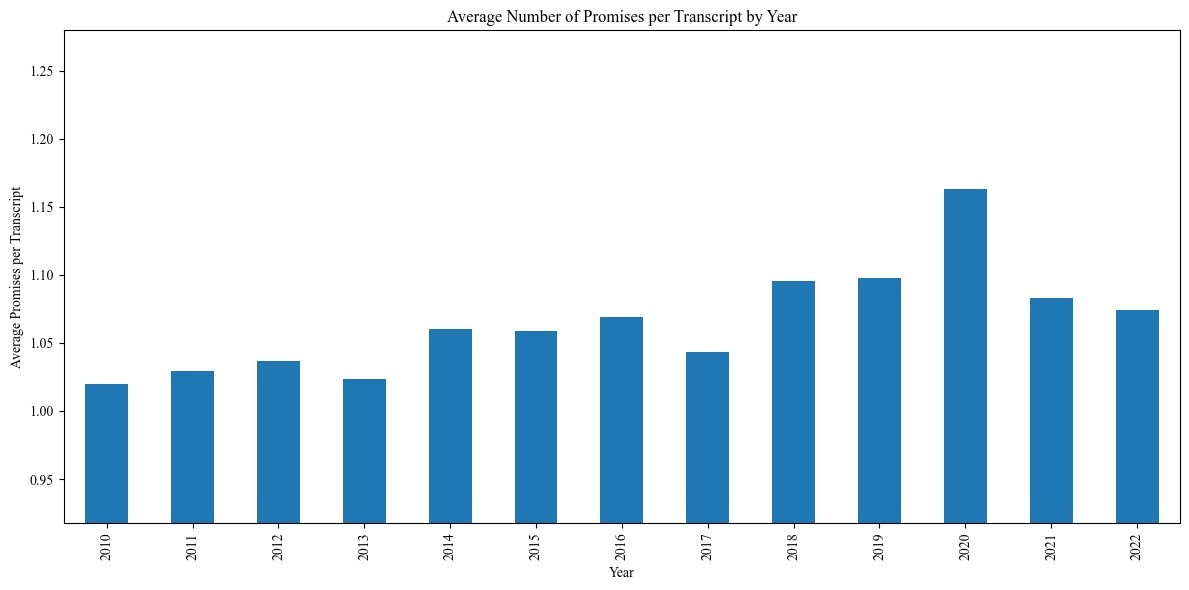

In [28]:
# Let's start with the analysis as requested. We will perform two main analyses:
# 1. Calculate the average number of promises per transcript in each year.
# 2. Calculate the average number of promises per 1000 words spoken in the presentation for each year.

# Grouping the data by year and calculating the average number of promises per transcript
avg_promises_per_transcript = transcripts.groupby('year').apply(lambda x: x['promise_count'].sum() / x['transcriptid'].nunique())


# Adjusting the graphs to show the bars from slightly below the lowest value to slightly above the highest value.

# Determining the range for the y-axis for the first graph (Average Number of Promises per Transcript by Year)
min_val_transcript = avg_promises_per_transcript.min() * 0.9
max_val_transcript = avg_promises_per_transcript.max() * 1.1


# Plotting the adjusted graphs
plt.figure(figsize=(12, 6))

# Adjusted plot for Average Number of Promises per Transcript by Year
plt.subplot(1, 1, 1)
avg_promises_per_transcript.plot(kind='bar')
plt.title('Average Number of Promises per Transcript by Year')
plt.xlabel('Year')
plt.ylabel('Average Promises per Transcript')
plt.ylim([min_val_transcript, max_val_transcript])

plt.savefig("../data/figures/number_promises_overyears_v10.png", dpi=900)

plt.tight_layout()
plt.show()

